In [7]:
!pip --version


pip 24.2 from C:\Users\Loc\AppData\Local\Programs\Python\Python310\lib\site-packages\pip (python 3.10)



In [8]:
!pip install selenium beautifulsoup4
!pip install pandas
!pip install requests


!pip install XlsxWriter


In [9]:
import re
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains


In [10]:

# Hàm kiểm tra kết nối internet
def check_internet():
    # URL trang web để kiểm tra kết nối, thường dùng Google vì nó ổn định
    url = 'http://www.google.com'
    # Thiết lập thời gian chờ (timeout) là 5 giây
    timeout = 5
    try:
        # Gửi yêu cầu GET đến Google với thời gian chờ 5 giây
        requests.get(url, timeout=timeout)
        # Nếu không có lỗi, kết nối internet đang hoạt động
        return True
    # Bắt ngoại lệ nếu có lỗi kết nối hoặc vượt quá thời gian chờ
    except (requests.ConnectionError, requests.Timeout):
        # Nếu có lỗi kết nối hoặc timeout, hàm sẽ trả về False
        return False

# Hàm lưu dữ liệu vào file
def save_links(data, file_name="link_collected.txt"):
    # Mở file trong chế độ "append" (thêm nội dung vào cuối file)
    with open(file_name, "a") as file:
        # Lặp qua từng mục (item) trong dữ liệu (data)
        for item in data:
            # Ghi từng mục vào file dưới dạng chuỗi và thêm xuống dòng
            file.write(f"{item}\n")



In [11]:
# Tạo đối tượng service để chỉ định đường dẫn tới file chromedriver
service = Service(executable_path="chromedriver.exe")
# Tạo driver Chrome với đối tượng service vừa khởi tạo
driver = webdriver.Chrome(service=service)

# Kiểm tra kết nối trước khi tiếp tục
if not check_internet():  # Nếu không có kết nối internet
    print("Không có kết nối internet. Đang chờ...")
    while not check_internet():  # Chờ cho đến khi có kết nối trở lại
        time.sleep(5)  # Kiểm tra lại sau mỗi 5 giây
    print("Đã khôi phục kết nối internet. Tiếp tục quá trình...")

# Mở trang Google
try:
    driver.get("https://google.com")
except Exception as e:
    # Nếu xảy ra lỗi (ví dụ: mất kết nối) khi mở Google
    print(f"Lỗi khi mở trang Google: {e}")
    while not check_internet():  # Chờ cho đến khi có kết nối trở lại
        print("Mất kết nối internet. Đang chờ...")
        time.sleep(5)
    print("Đã khôi phục kết nối internet. Tiếp tục...")
    driver.get("https://google.com")  # Mở lại Google khi có kết nối

# Chờ thanh tìm kiếm xuất hiện
try:
    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CLASS_NAME, "gLFyf"))
    )
except Exception as e:
    # Nếu xảy ra lỗi khi chờ đợi thanh tìm kiếm
    print(f"Lỗi khi chờ thanh tìm kiếm: {e}")
    while not check_internet():  # Chờ cho đến khi có kết nối trở lại
        print("Mất kết nối internet. Đang chờ...")
        time.sleep(5)
    print("Đã khôi phục kết nối internet. Tiếp tục...")

# Tương tác với thanh tìm kiếm
input_element = driver.find_element(By.CLASS_NAME, "gLFyf")  # Tìm thanh tìm kiếm bằng class name
input_element.send_keys("nguyenkim" + Keys.ENTER)  # Nhập từ khóa "nguyenkim" và nhấn Enter

# Xử lý CAPTCHA thủ công nếu có
# print("Chờ bạn xử lý CAPTCHA...")
# time.sleep(30)  # Dừng chương trình trong 30 giây để người dùng xử lý CAPTCHA
# print("Tiếp tục sau khi CAPTCHA đã được xử lý.")

# Chờ kết quả tìm kiếm xuất hiện và tìm liên kết của trang Nguyễn Kim
try:
    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.PARTIAL_LINK_TEXT, "Nguyễn Kim - Mua tủ lạnh, máy lạnh, tivi, máy giặt chính hãng"))
    )
except Exception as e:
    # Nếu xảy ra lỗi khi chờ kết quả tìm kiếm
    print(f"Lỗi khi chờ kết quả tìm kiếm: {e}")
    while not check_internet():  # Chờ cho đến khi có kết nối trở lại
        print("Mất kết nối internet. Đang chờ...")
        time.sleep(5)
    print("Đã khôi phục kết nối internet. Tiếp tục...")

# Nhấp vào liên kết trang Nguyễn Kim
try:
    click_result = driver.find_element(By.PARTIAL_LINK_TEXT, "Nguyễn Kim - Mua tủ lạnh, máy lạnh, tivi, máy giặt chính hãng")
    click_result.click()
except Exception as e:
    # Nếu xảy ra lỗi khi nhấp vào liên kết
    print(f"Lỗi khi nhấp vào liên kết: {e}")
    while not check_internet():  # Chờ cho đến khi có kết nối trở lại
        print("Mất kết nối internet. Đang chờ...")
        time.sleep(5)
    print("Đã khôi phục kết nối internet. Tiếp tục...")
    click_result = driver.find_element(By.PARTIAL_LINK_TEXT, "Nguyễn Kim - Mua tủ lạnh, máy lạnh, tivi, máy giặt chính hãng")
    click_result.click()  # Nhấp vào liên kết khi có kết nối

# Chờ thêm 10 giây để trang sản phẩm tải xong
time.sleep(10)


Lỗi khi chờ thanh tìm kiếm: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=130.0.6723.70)
Stacktrace:
	GetHandleVerifier [0x00007FF682B1FDA5+29557]
	(No symbol) [0x00007FF682A92240]
	(No symbol) [0x00007FF68294B6EA]
	(No symbol) [0x00007FF68291FCD5]
	(No symbol) [0x00007FF6829CF167]
	(No symbol) [0x00007FF6829E81A1]
	(No symbol) [0x00007FF6829C72A3]
	(No symbol) [0x00007FF6829912DF]
	(No symbol) [0x00007FF682992451]
	GetHandleVerifier [0x00007FF682E4DCBD+3363469]
	GetHandleVerifier [0x00007FF682E99B47+3674391]
	GetHandleVerifier [0x00007FF682E8EAEB+3629243]
	GetHandleVerifier [0x00007FF682BDFC66+815670]
	(No symbol) [0x00007FF682A9D6EF]
	(No symbol) [0x00007FF682A992B4]
	(No symbol) [0x00007FF682A99450]
	(No symbol) [0x00007FF682A881FF]
	BaseThreadInitThunk [0x00007FFC52B27374+20]
	RtlUserThreadStart [0x00007FFC53EDCC91+33]

Đã khôi phục kết nối internet. Tiếp tục...


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=130.0.6723.70)
Stacktrace:
	GetHandleVerifier [0x00007FF682B1FDA5+29557]
	(No symbol) [0x00007FF682A92240]
	(No symbol) [0x00007FF68294B6EA]
	(No symbol) [0x00007FF68291FCD5]
	(No symbol) [0x00007FF6829CF167]
	(No symbol) [0x00007FF6829E81A1]
	(No symbol) [0x00007FF6829C72A3]
	(No symbol) [0x00007FF6829912DF]
	(No symbol) [0x00007FF682992451]
	GetHandleVerifier [0x00007FF682E4DCBD+3363469]
	GetHandleVerifier [0x00007FF682E99B47+3674391]
	GetHandleVerifier [0x00007FF682E8EAEB+3629243]
	GetHandleVerifier [0x00007FF682BDFC66+815670]
	(No symbol) [0x00007FF682A9D6EF]
	(No symbol) [0x00007FF682A992B4]
	(No symbol) [0x00007FF682A99450]
	(No symbol) [0x00007FF682A881FF]
	BaseThreadInitThunk [0x00007FFC52B27374+20]
	RtlUserThreadStart [0x00007FFC53EDCC91+33]


In [ ]:
# Tạo danh sách lưu trữ các liên kết đã thu thập từ file (nếu có)
saved_links = []

# Khởi tạo biến link1 để chứa danh sách liên kết với bản sao của saved_links
link1 = saved_links.copy()  # Tạo bản sao để tránh sửa đổi danh sách gốc

# Tìm phần tử có class là 'nk-product-cate-homepage' và cuộn đến đó
scroll = driver.find_element(By.CLASS_NAME, 'nk-product-cate-homepage')
driver.execute_script("arguments[0].scrollIntoView();", scroll)  # Cuộn trang đến phần tử được tìm thấy
time.sleep(3)  # Tạm dừng 3 giây để đảm bảo trang tải xong sau khi cuộn

# Kiểm tra kết nối internet trước khi tiếp tục thu thập dữ liệu
if not check_internet():
    print("Không có kết nối internet. Đang chờ...")
    while not check_internet():  # Nếu mất kết nối, chờ cho đến khi khôi phục
        time.sleep(5)  # Kiểm tra lại sau mỗi 5 giây
    print("Đã khôi phục kết nối internet. Tiếp tục quá trình...")

# Tìm các phần tử chứa danh mục sản phẩm có class 'nk-content'
cl_tags = driver.find_elements(By.CLASS_NAME, 'nk-content')

# Lặp qua từng phần tử chứa danh mục sản phẩm
for tag in cl_tags:
    try:
        # Kiểm tra kết nối trong suốt quá trình thu thập
        if not check_internet():
            print("Không có kết nối internet. Đang dừng...")
            while not check_internet():  # Chờ đến khi có kết nối lại
                print("Chờ khôi phục kết nối...")
                time.sleep(5)
            print("Đã khôi phục kết nối. Tiếp tục thu thập dữ liệu...")

        # Lấy tất cả các phần tử <a> trong mỗi thẻ danh mục sản phẩm
        a_tags = tag.find_elements(By.TAG_NAME, 'a')
        for a_tag in a_tags:
            # Lấy thuộc tính 'href' của thẻ <a> để lấy đường dẫn liên kết
            href = a_tag.get_attribute('href')
            # Kiểm tra nếu link tồn tại và chưa có trong link1, thêm link vào danh sách
            if href and href not in link1:
                link1.append(href)  # Thêm link vào danh sách
                print(f"Thu thập link: {href}")
                save_links([href])  # Lưu link vào file ngay lập tức để tránh mất dữ liệu nếu ngắt kết nối
    except Exception as e:
        # Xử lý nếu có lỗi trong quá trình thu thập
        print(f"Đã xảy ra lỗi: {e}")

# Thông báo số lượng liên kết đã thu thập và lưu trữ
print(f"Đã thu thập và lưu {len(link1)} liên kết.")


Thu thập link: https://www.nguyenkim.com/may-lanh/
Thu thập link: https://www.nguyenkim.com/dien-thoai-di-dong/
Thu thập link: https://www.nguyenkim.com/tu-lanh/
Thu thập link: https://www.nguyenkim.com/tivi/
Thu thập link: https://www.nguyenkim.com/may-tinh-xach-tay/
Thu thập link: https://www.nguyenkim.com/may-giat/
Thu thập link: https://www.nguyenkim.com/quat-vi/?features_hash=65-148987-148986-5954
Thu thập link: https://www.nguyenkim.com/may-nuoc-nong/
Thu thập link: https://www.nguyenkim.com/may-in-van-phong/
Thu thập link: https://www.nguyenkim.com/noi-com-dien/
Thu thập link: https://www.nguyenkim.com/noi-chien-khong-dau/
Thu thập link: https://www.nguyenkim.com/may-loc-khong-khi/
Thu thập link: https://www.nguyenkim.com/man-hinh-lcd-vi-tinh/
Thu thập link: https://www.nguyenkim.com/may-ep-trai-cay/
Thu thập link: https://www.nguyenkim.com/may-loc-nuoc/
Thu thập link: https://www.nguyenkim.com/quat-vi/
Thu thập link: https://www.nguyenkim.com/bep-tu-hong-ngoai
Thu thập link: ht

In [ ]:
# Hàm lưu dữ liệu vào file
def save_data(data, file_name="data_products.txt"):
    # Mở file ở chế độ "a" (append - nối thêm vào cuối file) để ghi dữ liệu
    with open(file_name, "a") as file:
        # Lặp qua từng mục (item) trong danh sách data
        for item in data:
            # Ghi từng mục vào file và xuống dòng sau mỗi mục
            file.write(f"{item}\n")


In [ ]:
product_links = []  # Tạo một danh sách trống để lưu liên kết các sản phẩm

# Duyệt qua từng link danh mục sản phẩm trong danh sách link1
for link in link1:
    is_last_page = False  # Cờ kiểm tra xem đã đến trang cuối cùng của danh mục chưa
    
    while True:
        # Kiểm tra kết nối internet trước khi truy cập link
        if not check_internet():
            print("Không có kết nối internet. Đang chờ...")
            while not check_internet():  # Chờ đến khi có kết nối lại
                time.sleep(5)
            print("Đã khôi phục kết nối internet. Tiếp tục quá trình...")

        try:
            # Mở link danh mục sản phẩm trong trình duyệt
            driver.get(link)

            # Vòng lặp để duyệt qua tất cả các trang trong danh mục sản phẩm
            while not is_last_page:
                try:
                    # Chờ cho đến khi phần tử chứa sản phẩm được tải
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.XPATH, "//div[contains(@class, 'nk-product-cate-style-grid')]"))
                    )

                    # Lấy tất cả container sản phẩm
                    product_containers = driver.find_elements(By.XPATH, "//div[contains(@class, 'nk-product-cate-style-grid') and contains(@class, 'nk-product-collection')]")
                    
                    for container in product_containers:
                        # Kiểm tra lại kết nối internet trong quá trình thu thập dữ liệu
                        if not check_internet():
                            print("Không có kết nối internet. Đang chờ...")
                            while not check_internet():  # Chờ khôi phục kết nối
                                time.sleep(5)
                            print("Đã khôi phục kết nối internet. Tiếp tục quá trình...")

                        try:
                            # Lấy tất cả thẻ <a> chứa link sản phẩm trong container
                            a_tags = container.find_elements(By.TAG_NAME, 'a')
                            for a_tag in a_tags:
                                href = a_tag.get_attribute('href')
                                # Thêm link vào danh sách nếu chưa tồn tại trong product_links
                                if href and href not in product_links:
                                    product_links.append(href)  # Lưu link vào danh sách
                                    save_data([href])  # Ghi link vào file
                                    print(f"Link thu được: {href}")
                        except Exception as e:
                            print(f"Lỗi khi lấy link từ container sản phẩm: {e}")

                    # Kiểm tra nút chuyển trang tiếp theo
                    try:
                        next_page_button = driver.find_element(By.XPATH, "//div[contains(@class, 'NkReview_footer_col-3')]")
                        # Cuộn đến vị trí của nút
                        driver.execute_script("arguments[0].scrollIntoView(true);", next_page_button)
                        time.sleep(2)

                        # Kiểm tra nếu đây là trang cuối cùng
                        if not next_page_button.is_displayed():
                            is_last_page = True  # Đặt cờ kết thúc trang
                        else:
                            # Lấy link của trang tiếp theo và truy cập
                            a_tag = next_page_button.find_element(By.TAG_NAME, 'a')
                            href = a_tag.get_attribute('href')
                            driver.get(href)
                            time.sleep(3)
                    except:
                        print("Không tìm thấy trang tiếp theo. Chuyển sang danh mục khác.")
                        is_last_page = True  # Đặt cờ kết thúc danh mục hiện tại

                except Exception as e:
                    print(f"Lỗi thu thập: {e}")
                    is_last_page = True  # Kết thúc nếu có lỗi trong việc tải trang
                    break

            # Kết thúc danh mục sản phẩm hiện tại
            print("Đã xử lý xong danh mục. Chuyển sang danh mục tiếp theo.")
            break

        except Exception as e:
            print(f"Lỗi khi truy cập link: {e}")
            break  # Kết thúc danh mục hiện tại khi có lỗi truy cập


Link thu được: https://www.nguyenkim.com/may-lanh-casper-inverter-tc-09is35.html
Link thu được: https://www.nguyenkim.com/index.php?dispatch=product_features.add_product&product_id=128074
Link thu được: https://www.nguyenkim.com/may-lanh-panasonic-inverter-cu-cs-pu12zkh-8m.html
Link thu được: https://www.nguyenkim.com/index.php?dispatch=product_features.add_product&product_id=127689
Link thu được: https://www.nguyenkim.com/may-lanh-reetech-1-hp-rt9-rc9-ta-bt.html
Link thu được: https://www.nguyenkim.com/index.php?dispatch=product_features.add_product&product_id=128121
Link thu được: https://www.nguyenkim.com/may-lanh-panasonic-inverter-cu-cs-xu9zkh-8.html
Link thu được: https://www.nguyenkim.com/index.php?dispatch=product_features.add_product&product_id=127668
Link thu được: https://www.nguyenkim.com/may-lanh-daikin-ftky25wmvmv.html
Link thu được: https://www.nguyenkim.com/index.php?dispatch=product_features.add_product&product_id=116296
Link thu được: https://www.nguyenkim.com/may-lan

In [ ]:
print("Tổng link: ",len(product_links))

Tổng sản phẩm:  4379


In [ ]:
# Lọc link lỗi 404
filtered_links = [link for link in product_links if not link.startswith("https://www.nguyenkim.com/index.php?dispatch=product_features.add_product&product_id=")]

In [ ]:
print("Tổng số link thu được: ",len(filtered_links))

Tổng số link:  2204


In [ ]:
data = []  # Tạo danh sách trống để lưu thông tin từng sản phẩm
# Duyệt qua các liên kết sản phẩm trong filtered_links
for op_link in filtered_links:
    while True:
        # Kiểm tra kết nối internet trước khi truy cập trang
        if not check_internet():
            print("Không có kết nối internet. Đang chờ...")
            while not check_internet():  # Chờ kết nối lại
                time.sleep(5)
            print("Đã khôi phục kết nối internet. Tiếp tục quá trình...")
        
        try:
            # Mở liên kết sản phẩm
            driver.get(op_link)
            time.sleep(1)

            # Lấy tên sản phẩm
            try:
                name = driver.find_element(By.CLASS_NAME, "wrap_name_vote").find_element(By.TAG_NAME, 'h1').text
            except:
                name = "Sản phẩm không có tên"  # Gán giá trị mặc định nếu không tìm thấy tên
            
            # Lấy giá khuyến mãi của sản phẩm
            try:
                value_final = driver.find_element(By.CLASS_NAME, "product_info_price_value-final").find_element(By.TAG_NAME, 'span').text
            except:
                value_final = ""  # Gán giá trị rỗng nếu không tìm thấy giá khuyến mãi
            
            # Lấy giá ban đầu của sản phẩm
            try:
                value_real = driver.find_element(By.CLASS_NAME, "price_promotion").find_element(By.CLASS_NAME, "product_info_price_value-real").text
            except:
                value_real = value_final  # Nếu không có giá ban đầu, gán bằng giá khuyến mãi

            # Lấy thông tin chi tiết sản phẩm
            try:
                div_specification = driver.find_element(By.CLASS_NAME, "productSpecification_table")
                # Cuộn đến phần tử chứa thông tin chi tiết
                ActionChains(driver).move_to_element(div_specification).perform()
                time.sleep(2)

                # Lấy mã HTML của phần tử để phân tích bằng BeautifulSoup
                html_content = div_specification.get_attribute('outerHTML')
                print(html_content)
                soup = BeautifulSoup(html_content, 'html.parser')
                t_body = soup.find('tbody')
                rows = t_body.find_all('tr')[:7]  # Lấy tối đa 5 hàng thông tin

                # Xử lý dữ liệu chi tiết sản phẩm
                product_details = {}
                for i, row in enumerate(rows):
                    title = row.find('td', class_='title').text.strip()  # Lấy tiêu đề của thuộc tính
                    value = row.find('td', class_='value').text.strip()  # Lấy giá trị của thuộc tính
                    product_details[title] = value

                # Đảm bảo các trường thông tin cơ bản có mặt
                model = product_details.get("Model:", "")
                color = product_details.get("Màu sắc:", "")
                manufacturer = product_details.get("Nhà sản xuất:", "")
                origin = product_details.get("Xuất xứ:", "")
                release_year = product_details.get("Năm ra mắt :", "")
                guarantee_period = product_details.get("Thời gian bảo hành:", "")
            except Exception as e:
                # Nếu có lỗi, đặt các trường thông tin về rỗng
                print(f"Lỗi khi lấy thông tin sản phẩm: {e}")
                model = color = manufacturer = origin = release_year = guarantee_period = ""

            # Thêm thông tin sản phẩm vào danh sách
            data.append({
                'Tên sản phẩm': name,
                'Giá khuyến mãi': value_final,
                'Giá ban đầu': value_real,
                'Model': model,
                'Màu sắc': color,
                'Nhà sản xuất': manufacturer,
                'Xuất xứ': origin,
                'Năm ra mắt': release_year,
                'Thời gian bảo hành': guarantee_period
            })
        
        except Exception as e:
            # Bắt và in thông báo lỗi nếu không truy cập được link sản phẩm
            print(f"Lỗi: {e}")
            break
        
        break  # Thoát vòng lặp khi xử lý xong sản phẩm

# Tạo DataFrame từ danh sách dữ liệu sản phẩm
data_df = pd.DataFrame(data)


<table class="productSpecification_table"><caption class="productSpecification_title">Thông số kỹ thuật</caption><tbody><tr><td class="title">Model:</td><td class="value"> TC-09IS35 </td></tr><tr><td class="title">Màu sắc:</td><td class="value"> Trắng </td></tr><tr><td class="title">Nhà sản xuất:</td><td class="value"> Casper </td></tr><tr><td class="title">Xuất xứ:</td><td class="value"> Thái Lan </td></tr><tr><td class="title">Năm ra mắt :</td><td class="value"> 2023 </td></tr><tr><td class="title">Thời gian bảo hành:</td><td class="value"> 36 Tháng </td></tr><tr><td class="title">Địa điểm bảo hành:</td><td class="value"> Nguyễn Kim </td></tr><tr><td class="title">Loại máy lạnh:</td><td class="value"> Máy lạnh 1 chiều (chỉ làm lạnh) </td></tr><tr><td class="title">Kiểu dáng:</td><td class="value"> Máy lạnh treo tường </td></tr><tr><td class="title">Công suất:</td><td class="value"> 1 HP </td></tr></tbody></table>
<table class="productSpecification_table"><caption class="productSpecif

In [ ]:
data_df

,Tên sản phẩm,Giá khuyến mãi,Giá ban đầu,Model,Màu sắc,Nhà sản xuất,Xuất xứ,Năm ra mắt,Thời gian bảo hành
0,Máy lạnh Casper Inverter 1 HP TC-09IS35,6.490.000đ,7.490.000đ,TC-09IS35,Trắng,Casper,Thái Lan,2023,36 Tháng
1,Máy lạnh Panasonic Inverter 1.5 HP CU/CS-PU12Z...,13.890.000đ,15.970.000đ,CU/CS-PU12ZKH-8M,Trắng,Panasonic,Malaysia,2023,12 Tháng
2,Máy lạnh Reetech 1 HP RT9/RC9-TA-BT,5.790.000đ,7.190.000đ,RT9-TA-BT/RC9-TA-BT,Trắng,Reetech,Thái Lan,2023,"24 tháng toàn máy, 60 tháng máy nén"
3,Máy lạnh Panasonic Inverter 1 HP CU/CS-XU9ZKH-8,13.990.000đ,16.090.000đ,CU/CS-XU9ZKH-8,Trắng,Panasonic,Malaysia,2023,12 Tháng
4,Máy lạnh Daikin Inverter 1 HP FTKY25WMVMV,12.490.000đ,13.990.000đ,FTKY25WMVMV/RKY25WMVMV,Trắng,Daikin,Việt Nam,2022,12 Tháng
...,...,...,...,...,...,...,...,...,...
2081,Máy duỗi tóc Dyson Corrale™ (Hồng/Xám Trắng),13.990.000đ,13.990.000đ,HS07,Hồng/Xám trắng,Dyson,Philippines,2024,24 Tháng
2082,Máy duỗi tóc Dyson Corrale™ HS07 (Xám Đen/Hồng...,13.990.000đ,13.990.000đ,HS07,Xám đen/Hồng Fuchsia,Dyson,Philippines,2024,24 Tháng
2083,Máy tạo kiểu tóc Dyson Airwrap Complete Long H...,14.690.000đ,15.690.000đ,HS05,Xám trắng và Đồng,Dyson,Malaysia,2022,24 Tháng
2084,Máy tạo kiểu tóc Dyson Airwrap Complete HS05,14.690.000đ,15.690.000đ,HS05,,Dyson,Malaysia,2022,24 Tháng


In [54]:
data_df.to_excel("output.xlsx", index=False)

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
# Đọc dữ liệu từ file excel 
data_df = pd.read_excel("output.xlsx")


In [56]:
# Danh sách danh mục sản phẩm
categories = [
    "Máy lạnh", "Điện thoại", "Tủ lạnh", "Tivi", "Laptop", "Máy giặt", 
    "Quạt hơi nước", "Máy nước nóng", "Máy in", "Nồi cơm điện", 
    "Nồi chiên không dầu", "Máy lọc không khí", "Màn hình", "Máy ép", 
    "Máy lọc nước", "Quạt điện", "Bếp điện", "Loa", "Bếp điện", "Máy sấy tóc"
]



In [57]:
# Câu 1:- tính tất cả số lượng sản phẩm của nguyễn kim
total_products = len(data_df)

# In ra tổng số lượng sản phẩm
print("Tổng số lượng sản phẩm của Nguyễn Kim:", total_products)

Tổng số lượng sản phẩm của Nguyễn Kim: 2086


{'Máy lạnh': 143, 'Điện thoại': 180, 'Tủ lạnh': 208, 'Tivi': 211, 'Laptop': 118, 'Máy giặt': 198, 'Quạt hơi nước': 0, 'Máy nước nóng': 62, 'Máy in': 46, 'Nồi cơm điện': 151, 'Nồi chiên không dầu': 66, 'Máy lọc không khí': 49, 'Màn hình': 25, 'Máy ép': 48, 'Máy lọc nước': 93, 'Quạt điện': 0, 'Bếp điện': 4, 'Loa': 77, 'Máy sấy tóc': 42}


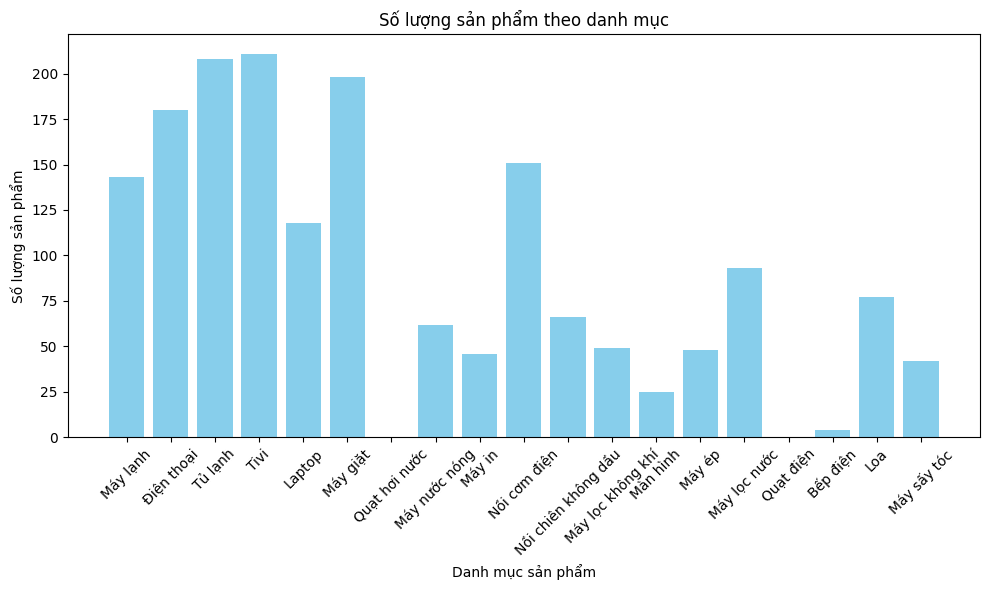

In [58]:
# câu 2: - Nguyễn Kim bán những doanh mục sản phẩm nào, mỗi doanh mục chiếm bao nhiêu sản phẩm

category_counts = {category: 0 for category in categories} # dùng để khởi tạo 1 từ điển khi lặp qua từng phần tử trong ds

# Đếm số lượng sản phẩm cho từng danh mục
for index, row in data_df.iterrows():
    for category in categories:
        if category in row['Tên sản phẩm']:  # Nếu tên sản phẩm chứa danh mục
            category_counts[category] += 1

# In ra số lượng sản phẩm theo từng danh mục
print(category_counts)

# Vẽ biểu đồ 
plt.figure(figsize=(10, 6))  # Tạo một hình ảnh mới với kích thước 10x6 inch
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')  # Vẽ biểu đồ cột với tên danh mục là trục x và số lượng sản phẩm là trục y, cột có màu xanh nhạt
plt.xlabel('Danh mục sản phẩm')  # Đặt nhãn cho trục x
plt.ylabel('Số lượng sản phẩm')  # Đặt nhãn cho trục y
plt.title('Số lượng sản phẩm theo danh mục')  # Đặt tiêu đề cho biểu đồ
plt.xticks(rotation=45)  # Xoay nhãn trên trục x 45 độ để dễ đọc hơn
plt.tight_layout()  # Tự động điều chỉnh bố cục để tránh chồng chéo
plt.show()  # Hiển thị biểu đồ




In [59]:
# Câu 3: Lấy ra danh sách các nhà sản xuất
manufacturers = data_df['Nhà sản xuất'].dropna().unique()

# Hiển thị danh sách các nhà sản xuất
print("Danh sách nhà sản xuất:")
for i in range(0, len(manufacturers), 15): # xuống dòng sau mỗi 15 nhà sản xuất
    print(" | ".join(manufacturers[i:i+15]))




Danh sách nhà sản xuất:
Casper | Panasonic | Reetech | Daikin | Mitsubishi Electric | Sharp | Toshiba | Aqua | LG | Comfee | TCL | Hitachi | Samsung | Midea | Nokia
iPhone | Realme | OPPO | Xiaomi | Apple | Vivo | Itel | Electrolux | Hisense | Toshiba (Tivi) | Sony | Dell | Asus | HP | Acer
Lenovo | MSI | Mabe | Rapido | Kangaroo | Magic Eco | Sunhouse | Iruka | Boss | Ariston | Centon | Ferroli | Alpha | Brother | Canon
Epson | Gaabor | Happy Cook | Coclear | Bear | Tefal | BlueStone | Cuckoo | Supor | Daewoo | Philips | Cookin | Zojirushi | Tiger | Hawonkoo
Torino | Magic | Shimono | Hafele | Kalite | Elmich | Unie | Steba | Coway | Dyson | Mutosi | Kuvings | Smeg | Pureit | Korihome
Karofi | AOSmith | Comet | Perfect | Senko | Asia | Nanoco | Lydsto | AC | Lofans | Goldsun | KDK | Stadler Form | Hayasa | Sanaky
Kiwa | Funiki | Junger | Teka | Pramie | Sakura | Steiger | Bosch | Acnos | iCore | Microtek | Guinness | BN | Nova Audio | Sumico
Boston | JBL | Paramax | RKB | Jamo | Bosto

C:\Users\Loc\AppData\Local\Temp\ipykernel_19396\656626501.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_counts = top_manufacturers.append(pd.Series({'Khác': other_count}))


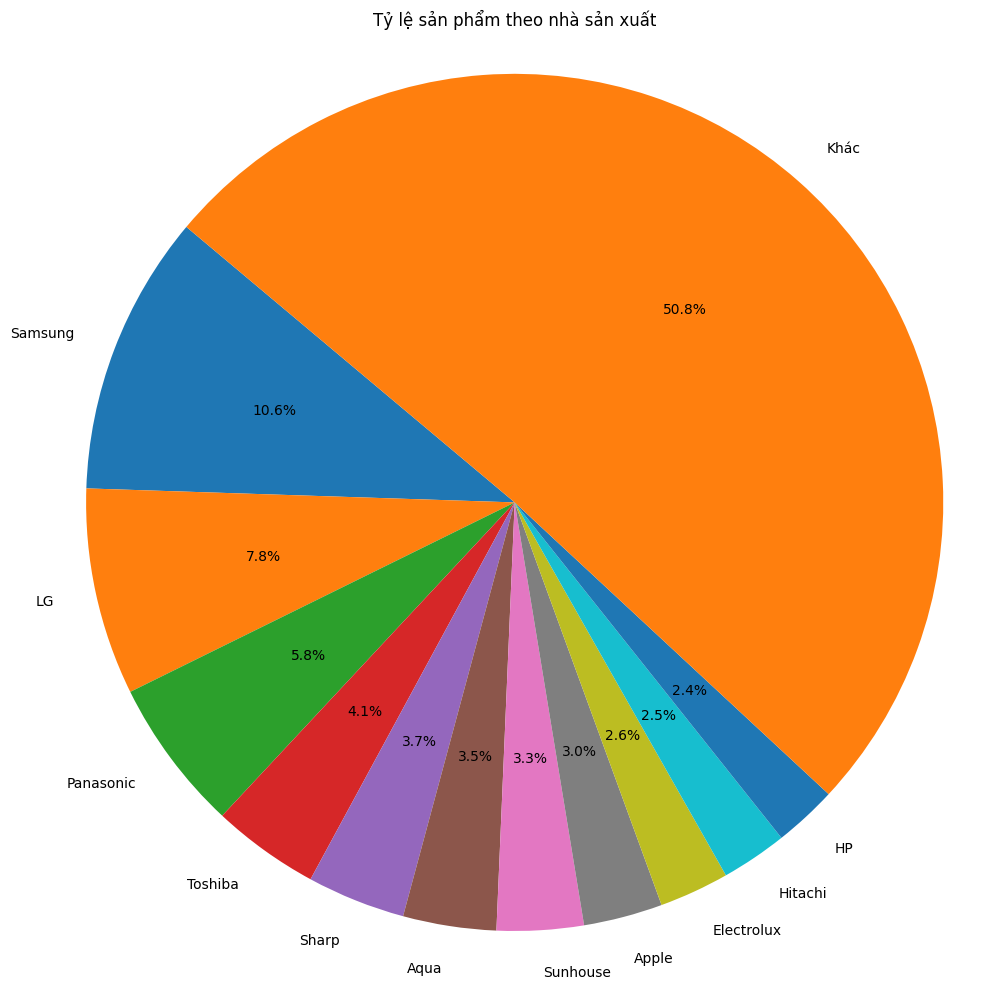

In [60]:
# Câu 4: Tính số lượng sản phẩm theo từng nhà sản xuất

manufacturer_product_counts = data_df['Nhà sản xuất'].value_counts()

# Tính tổng số sản phẩm để tính tỷ lệ
total_products = manufacturer_product_counts.sum()

# Tính tỷ lệ phần trăm cho từng nhà sản xuất
manufacturer_percentages = manufacturer_product_counts / total_products * 100

# Ngưỡng để nhóm các nhà sản xuất ít sản phẩm vào "Khác"
threshold_percentage = 2  # 1%

# Chia các nhà sản xuất thành hai nhóm: 'nổi bật' và 'khác'
top_manufacturers = manufacturer_product_counts[manufacturer_percentages >= threshold_percentage]
other_count = manufacturer_product_counts[manufacturer_percentages < threshold_percentage].sum()

# Tạo dữ liệu cho biểu đồ
final_counts = top_manufacturers.append(pd.Series({'Khác': other_count}))

# Vẽ biểu đồ tròn
plt.figure(figsize=(10, 10))
plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Tỷ lệ sản phẩm theo nhà sản xuất')
plt.axis('equal')  # Đảm bảo hình tròn
plt.tight_layout()
plt.show()


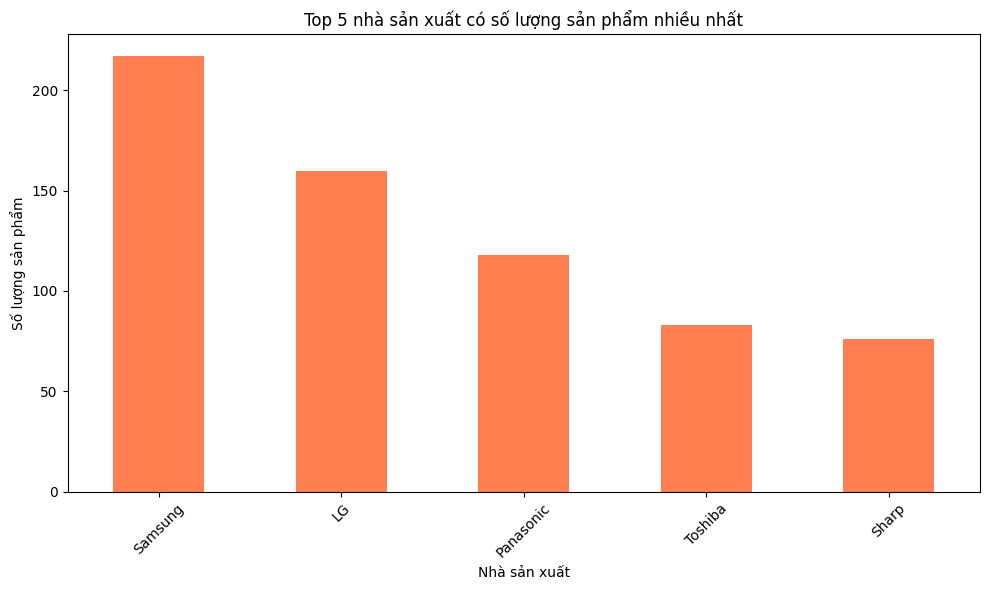

In [61]:
 # câu 5 Tỉ lệ sản phẩm của cấc nsx (top 5)
top_manufacturers = data_df['Nhà sản xuất'].value_counts().nlargest(5)  # Top 5 nhà sản xuất

# Vẽ biểu đồ cột cho top 5 nhà sản xuất
plt.figure(figsize=(10, 6))  # Kích thước biểu đồ
top_manufacturers.plot(kind='bar', color='coral')  # Vẽ biểu đồ cột
plt.xlabel('Nhà sản xuất')  # Nhãn cho trục x
plt.ylabel('Số lượng sản phẩm')  # Nhãn cho trục y
plt.title('Top 5 nhà sản xuất có số lượng sản phẩm nhiều nhất')  # Tiêu đề
plt.xticks(rotation=45)  # Xoay nhãn
plt.tight_layout()  # Điều chỉnh bố cục
plt.show()  # Hiển thị biểu đồ

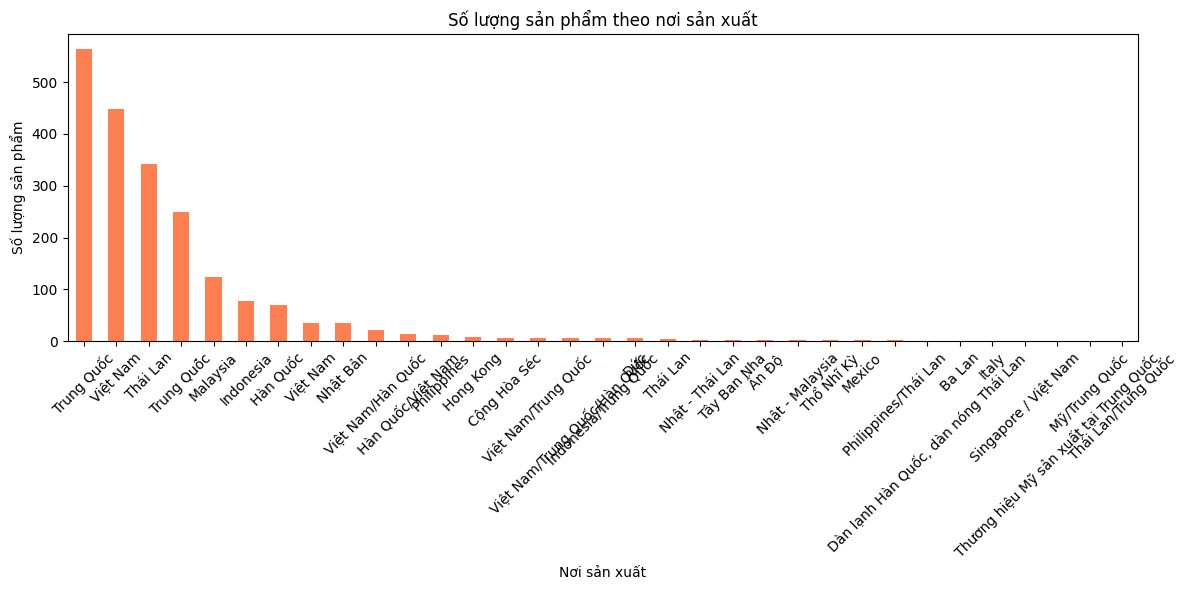

In [62]:
# Câu 6: Nơi sản xuất và số lượng 
origin_counts = data_df['Xuất xứ'].value_counts()

# Vẽ biểu đồ cho câu 5
plt.figure(figsize=(12, 6))
origin_counts.plot(kind='bar', color='coral')
plt.xlabel('Nơi sản xuất')
plt.ylabel('Số lượng sản phẩm')
plt.title('Số lượng sản phẩm theo nơi sản xuất')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

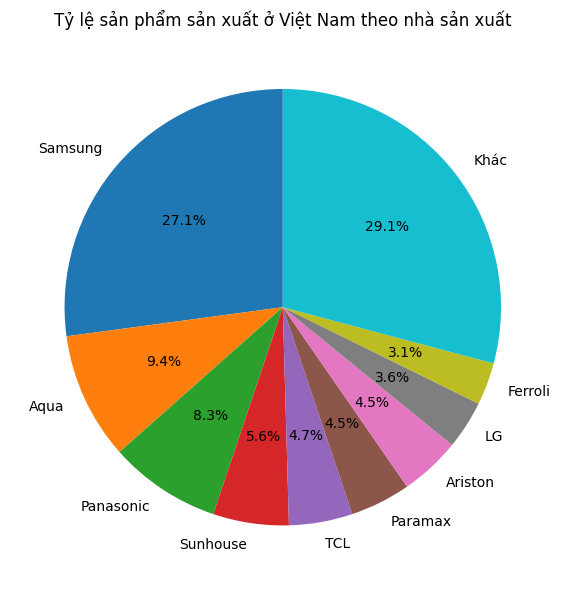

In [64]:
# Câu 7: Tìm tất cả sản phẩm sản xuất ở Việt Nam và đếm số lượng sản phẩm của các nhà sản xuất
# Lọc sản phẩm sản xuất ở Việt Nam
vietnam_products = data_df[data_df['Xuất xứ'] == 'Việt Nam']

# Đếm số lượng sản phẩm theo nhà sản xuất
vietnam_manufacturer_counts = vietnam_products['Nhà sản xuất'].value_counts()

# Tính tổng số sản phẩm
total_products = vietnam_manufacturer_counts.sum()

# Tính tỷ lệ phần trăm cho mỗi nhà sản xuất
manufacturer_percentages = (vietnam_manufacturer_counts / total_products) * 100

# Gộp các nhà sản xuất có tỷ lệ dưới 2% vào "Khác"
grouped_counts = manufacturer_percentages[manufacturer_percentages >= 3]
other_count = manufacturer_percentages[manufacturer_percentages < 3].sum()
grouped_counts['Khác'] = other_count

# Vẽ biểu đồ tròn
plt.figure(figsize=(12, 6))
grouped_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ sản phẩm sản xuất ở Việt Nam theo nhà sản xuất')
plt.ylabel('')  # Xóa nhãn y
plt.tight_layout()
plt.show()

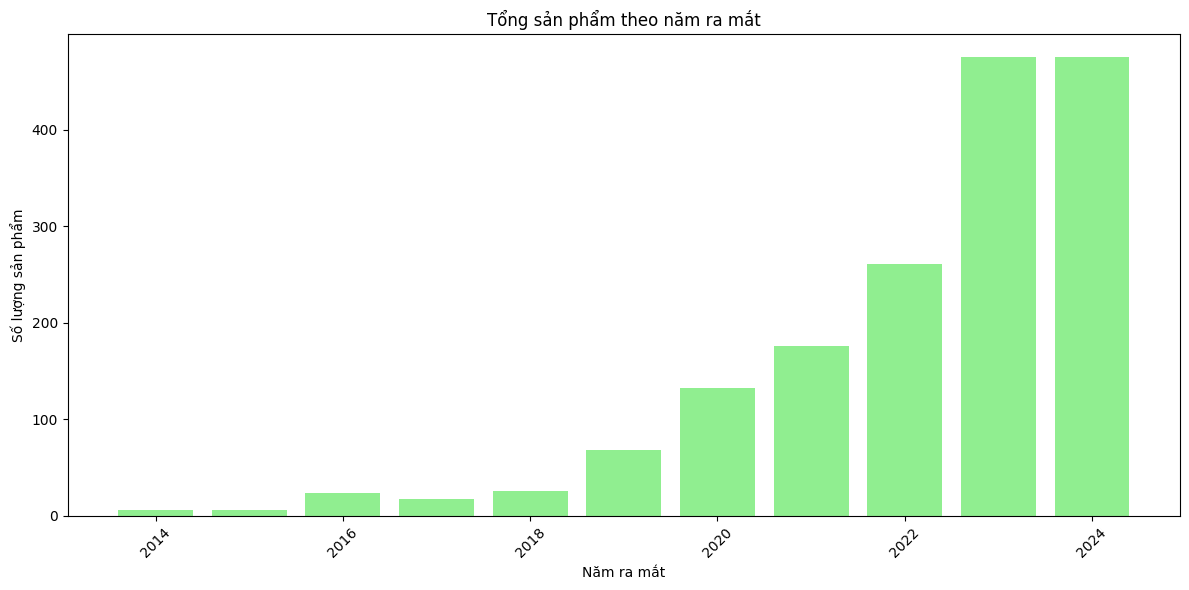

In [65]:
# Câu 8: Tính tổng số sản phẩm theo năm ra mắt
# Lọc các giá trị năm hợp lệ từ 2014 đến 2024
valid_years = data_df['Năm ra mắt'].astype(str).str.isnumeric()  # Kiểm tra các giá trị là số
data_df = data_df[valid_years]  # Giữ lại các dòng có năm hợp lệ

# Chuyển đổi cột 'Năm ra mắt' sang kiểu số nguyên
data_df['Năm ra mắt'] = pd.to_numeric(data_df['Năm ra mắt'], errors='coerce')

# Giữ lại chỉ các năm trong khoảng từ 2014 đến 2024
data_df = data_df[(data_df['Năm ra mắt'] >= 2014) & (data_df['Năm ra mắt'] <= 2024)]

# Tính tổng số sản phẩm theo năm ra mắt
year_counts = data_df['Năm ra mắt'].value_counts().sort_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(year_counts.index, year_counts.values, color='lightgreen')
plt.xlabel('Năm ra mắt')
plt.ylabel('Số lượng sản phẩm')
plt.title('Tổng sản phẩm theo năm ra mắt')
plt.xticks(rotation=45)  # Xoay nhãn cho rõ ràng hơn
plt.tight_layout()
plt.show()

In [87]:
# câu 9 Tìm các sản phẩm ra mắt trước năm 2018
products_before_2018 = data_df[data_df['Năm ra mắt'] < 2018]

# In ra kết quả
print("Các sản phẩm ra mắt trước năm 2018:")
print(products_before_2018[['Tên sản phẩm', 'Năm ra mắt', 'Nhà sản xuất']])  # In các cột mong muốn




Các sản phẩm ra mắt trước năm 2018:
                                         Tên sản phẩm  Năm ra mắt Nhà sản xuất
504   Tủ lạnh Hitachi Inverter 615 lít R-WX620KV (XK)        2017      Hitachi
1280             Nồi cơm điện Cuckoo 1.08 lít CR-0661        2016       Cuckoo
1291              Nồi cơm điện Cuckoo 1.8 lít CR-1021        2016       Cuckoo
1364               Nồi cơm điện Cuckoo CRP-CHSS1009FN        2017       Cuckoo
1527                   Máy ép trái cây Philips HR1811        2014      Philips
1553                   Máy ép trái cây Philips HR1863        2014      Philips
1699                         Quạt hộp Asia F16001 Xám        2017         Asia
1776                              Quạt trần KDK T60AW        2014          KDK
2038                    Máy sấy tóc Philips HP8108/00        2016      Philips
2046               Máy sấy tóc Philips BHC010/00 Hồng        2016      Philips
2063                    Máy sấy tóc Philips BHD300/10        2016      Philips


: 

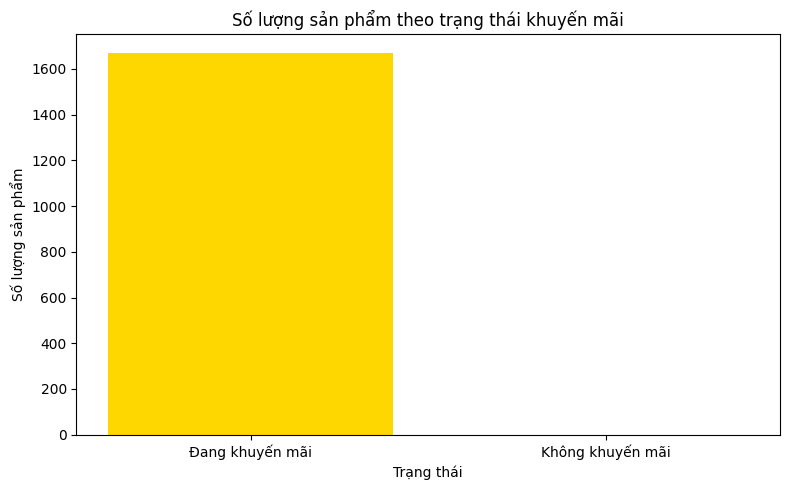

In [66]:
# câu 10
# Tính số lượng sản phẩm đang khuyến mãi và không khuyến mãi
discounted_products_count = data_df[data_df['Giá khuyến mãi'] != data_df['Giá ban đầu']].shape[0]
non_discounted_products_count = data_df[data_df['Giá khuyến mãi'] == data_df['Giá ban đầu']].shape[0]

# Vẽ biểu đồ số lượng sản phẩm đang khuyến mãi và không khuyến mãi
plt.figure(figsize=(8, 5))  # Kích thước biểu đồ
plt.bar(['Đang khuyến mãi', 'Không khuyến mãi'], 
        [discounted_products_count, non_discounted_products_count], 
        color=['gold', 'lightgray'])  # Màu sắc cho từng cột

plt.xlabel('Trạng thái')  # Nhãn cho trục x
plt.ylabel('Số lượng sản phẩm')  # Nhãn cho trục y
plt.title('Số lượng sản phẩm theo trạng thái khuyến mãi')  # Tiêu đề cho biểu đồ
plt.xticks(rotation=0)  # Không xoay nhãn
plt.tight_layout()  # Điều chỉnh bố cục
plt.show()  # Hiển thị biểu đồ

In [67]:
# câu 11: Tìm 5 sản phẩm có giá cao nhất và thấp nhất
# Đảm bảo các cột giá được chuyển đổi sang định dạng số
data_df['Giá khuyến mãi'] = data_df['Giá khuyến mãi'].astype(str).str.replace('đ', '').str.replace('.', '').str.strip()
data_df['Giá ban đầu'] = data_df['Giá ban đầu'].astype(str).str.replace('đ', '').str.replace('.', '').str.strip()

# Chuyển đổi sang float, loại bỏ giá trị không hợp lệ
data_df['Giá khuyến mãi'] = pd.to_numeric(data_df['Giá khuyến mãi'], errors='coerce')
data_df['Giá ban đầu'] = pd.to_numeric(data_df['Giá ban đầu'], errors='coerce')

# Tìm 5 sản phẩm có giá ban đầu cao nhất
top_5_expensive_products = data_df.nlargest(5, 'Giá ban đầu')

# Tìm 5 sản phẩm có giá ban đầu thấp nhất
top_5_cheapest_products = data_df.nsmallest(5, 'Giá ban đầu')

# In ra thông tin sản phẩm
print("5 sản phẩm có giá cao nhất:")
print(top_5_expensive_products[['Tên sản phẩm', 'Giá ban đầu']])

print("\n5 sản phẩm có giá thấp nhất:")
print(top_5_cheapest_products[['Tên sản phẩm', 'Giá ban đầu']])


5 sản phẩm có giá cao nhất:
                                          Tên sản phẩm  Giá ban đầu
684  Tivi Micro LED Samsung 4K 110 inch MNA110MS1ACXXV   3499000000
695   Tivi Micro LED Samsung 4K 99 inch MNA99MS1AACXXV   2999000000
708    Tivi Neo QLED Samsung 8K 98 inch QA98QN990CKXXV    949000000
657  Smart Tivi Neo QLED Samsung 8K 85 inch QA85QN9...    219900000
701          Smart Tivi QNED LG 8K 86 Inch 86QNED99SQB    219900000

5 sản phẩm có giá thấp nhất:
                            Tên sản phẩm  Giá ban đầu
243   Điện Thoại Itel IT2171 2 Sim (Đen)       230000
2035          Máy sấy tóc Coclear CH6613       269000
1667          Quạt sạc Perfect PF-QB2170       280000
2037      Máy sấy tóc Bluestone HDB-1827       280000
2038       Máy sấy tóc Philips HP8108/00       339000


C:\Users\Loc\AppData\Local\Temp\ipykernel_19396\623330070.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_df['Giá khuyến mãi'] = data_df['Giá khuyến mãi'].astype(str).str.replace('đ', '').str.replace('.', '').str.strip()
C:\Users\Loc\AppData\Local\Temp\ipykernel_19396\623330070.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_df['Giá ban đầu'] = data_df['Giá ban đầu'].astype(str).str.replace('đ', '').str.replace('.', '').str.strip()


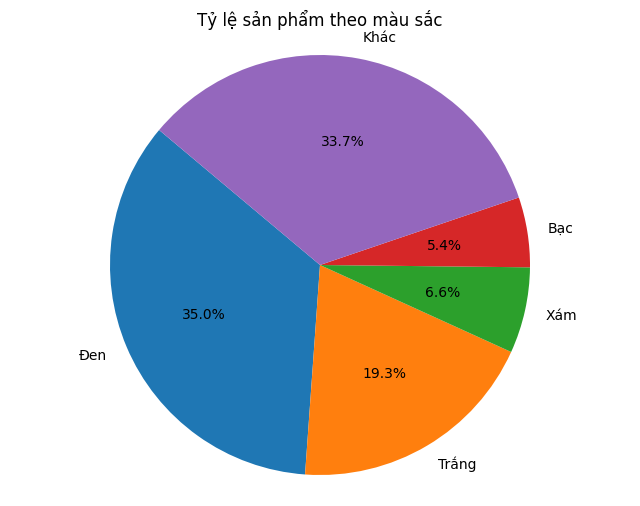

In [68]:
# câu 12 Tính số lượng sản phẩm theo màu sắc
color_counts = data_df['Màu sắc'].value_counts()  # Đếm số lượng theo từng màu sắc

# Tính tổng số sản phẩm
total_products = color_counts.sum()

# Nhóm các màu sắc có tỷ lệ dưới 1%
threshold = 0.019  # 1%
grouped_colors = color_counts[color_counts / total_products < threshold]
remaining_colors = color_counts[color_counts / total_products >= threshold]

# Tạo một danh sách màu sắc mới với phần "Khác"
if not grouped_colors.empty:
    remaining_colors['Khác'] = grouped_colors.sum()

# Vẽ biểu đồ tròn cho tỷ lệ sản phẩm theo màu sắc
plt.figure(figsize=(8, 6))  # Kích thước biểu đồ
plt.pie(remaining_colors, labels=remaining_colors.index, autopct='%1.1f%%', startangle=140)  # Vẽ biểu đồ tròn
plt.title('Tỷ lệ sản phẩm theo màu sắc')  # Tiêu đề
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.show()  # Hiển thị biểu đồ

In [69]:
# Câu 13: Tìm ra điện thoại Iphone 16 và đếm số lượng các màu hiện bày bán;
# Bước 1: Lọc các sản phẩm iPhone 16
iphone_16_products = data_df[data_df['Tên sản phẩm'].str.contains('iPhone 16', case=False, na=False)]

# Bước 2: Nhóm theo màu sắc
grouped_by_color = iphone_16_products.groupby('Màu sắc').size().reset_index(name='Số lượng')

# In kết quả
print("Các sản phẩm iPhone 16 phân loại theo màu sắc:")
print(grouped_by_color)

Các sản phẩm iPhone 16 phân loại theo màu sắc:
          Màu sắc  Số lượng
0            Hồng         4
1    Titan Sa Mạc         1
2     Titan Trắng         4
3  Titan Tự Nhiên         4
4       Titan Đen         4
5           Trắng         6
6   Xanh Mòng Két         4
7     Xanh lưu ly         4
8             Đen         6


In [70]:
# Câu 14 :Lọc các sản phẩm là máy lạnh và có nhà sản xuất là Casper
casper_air_conditioners = data_df[(data_df['Tên sản phẩm'].str.contains('máy lạnh', case=False, na=False)) & 
                                   (data_df['Nhà sản xuất'].str.contains('Casper', case=False, na=False))]

# In ra kết quả theo định dạng nằm ngang
print("Các sản phẩm máy lạnh của nhà sản xuất Casper:")
print(casper_air_conditioners[['Tên sản phẩm', 'Nhà sản xuất', 'Giá khuyến mãi', 'Xuất xứ', 'Năm ra mắt']].to_string(index=False))


Các sản phẩm máy lạnh của nhà sản xuất Casper:
                             Tên sản phẩm Nhà sản xuất  Giá khuyến mãi  Xuất xứ  Năm ra mắt
  Máy lạnh Casper Inverter 1 HP TC-09IS35       Casper    6.490000e+18 Thái Lan        2023
  Máy lạnh Casper Inverter 1 HP GC-09IS35       Casper    6.990000e+18 Thái Lan        2023
Máy lạnh Casper Inverter 1.5 HP GC-12IS35       Casper    7.890000e+18 Thái Lan        2023
Máy lạnh Casper Inverter 1.5 HP QC-12IS36       Casper    8.990000e+18 Thái Lan        2024
  Máy lạnh Casper Inverter 1 HP QC-09IS36       Casper    7.990000e+18 Thái Lan        2024
Máy lạnh Casper Inverter 2.5 HP GC-24IS35       Casper    1.559000e+22 Thái Lan        2023
  Máy lạnh Casper Inverter 2 HP TC-18IS36       Casper    1.179000e+22 Thái Lan        2024
  Máy lạnh Casper Inverter 1 HP XH-09IF35       Casper    1.059000e+22 Thái Lan        2023


In [82]:
# câu 15 Lọc các sản phẩm có thời gian bảo hành là 24 tháng
twenty_four_months_products = data_df[data_df['Thời gian bảo hành'] == 24]

# Đếm tổng số sản phẩm
total_twenty_four_months = twenty_four_months_products.shape[0]

# In ra kết quả
print("Tổng số sản phẩm có thời gian bảo hành là 24 tháng:", total_twenty_four_months)



Tổng số sản phẩm có thời gian bảo hành là 24 tháng: 648
